# REP price and OI approximation


Importing necessary libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import time
import datetime
import gc
import seaborn as sns
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump, load
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [21]:
openInterestInEth.to_csv("../data/processed/openInterestInEth.csv")

In [26]:
openInterestInEth = pd.read_csv("../data/processed/openInterestInEth.csv")

## Linear regression

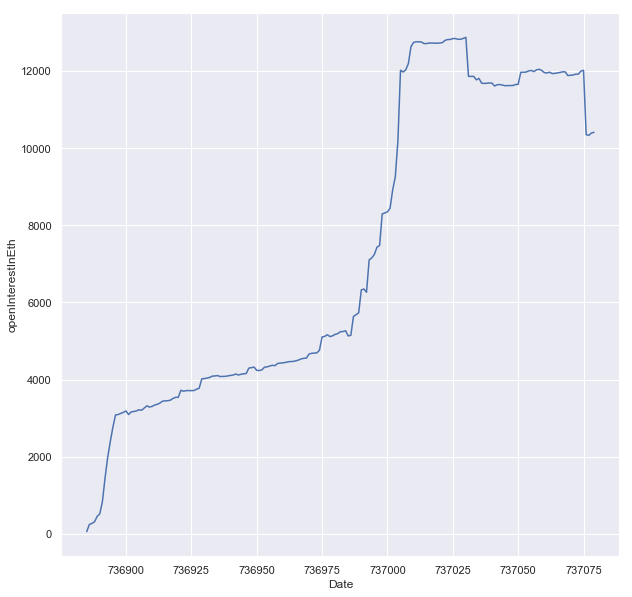

In [27]:
ax = sns.lineplot(x="Date", y="openInterestInEth", data=openInterestInEth, legend="full")
sns.set(rc={'figure.figsize':(10,10)})

In [24]:
openInterestInEth = openInterestInEth[(openInterestInEth["Date"]<737080)]

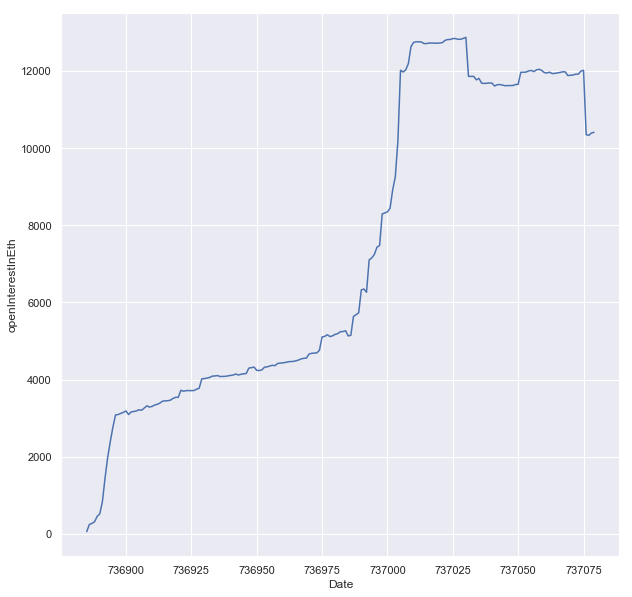

In [25]:
ax = sns.lineplot(x="Date", y="openInterestInEth", data=openInterestInEth, legend="full")
sns.set(rc={'figure.figsize':(10,10)})

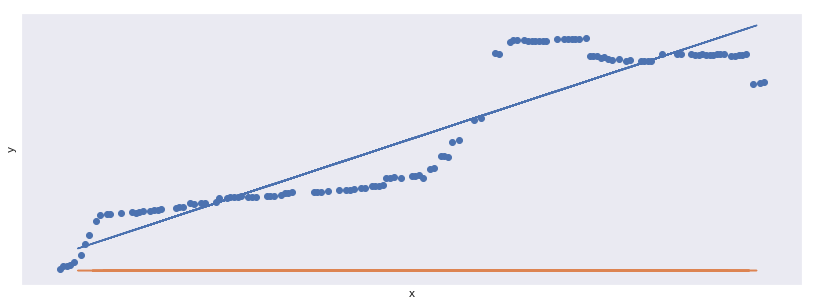

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

np.random.seed(0)


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

X = openInterestInEth['Date'].values.reshape(-1, 1)
y = openInterestInEth['openInterestInEth'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

plt.figure(figsize=(14, 5))

ax = plt.subplot(1, 1, 1)
plt.setp(ax, xticks=(), yticks=())

polynomial_features = PolynomialFeatures(degree=1,
                                         include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
pipeline.fit(X_train, y_train)

# Evaluate the models using crossvalidation
scores = cross_val_score(pipeline, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
plt.plot(X_test, pipeline.predict(X_test), label="Model")
plt.plot(X_test, true_fun(X_test), label="True function")
plt.scatter(X_train, y_train, edgecolor='b', label="Samples")
plt.xlabel("x")
plt.ylabel("y")

plt.show()

In [116]:
data = {'Date': ['2020-05-05', '2022-05-05']}
data = pd.DataFrame.from_dict(data)
data['Date'] =  pd.to_datetime(data['Date'])
data['Date'].map(dt.datetime.toordinal)

0    737550
1    738280
Name: Date, dtype: int64

In [117]:
X_predict =  np.array(737550).reshape(-1, 1)
pipeline.predict(X_predict)

array([[44811.99371511]])

In [118]:
X_predict =  np.array(738280).reshape(-1, 1)
pipeline.predict(X_predict)

array([[93030.18401755]])

# REP Price Prediction

In [ ]:
#Failed Experiments

### The next step is to obtain some pricing data. For this we will use coinmarketcap.com Can you write another script or otherwise scrape historical pricing data for REP from https://www.coinmarketcap.com ?


In [24]:
def get_market_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                                     "/historical-data/?start=20180710&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    if tag:
        market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
        return market_data

def merge_data(data_frames,from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='outer'), data_frames)
  return merged_data

def add_volatility(data, coins=['REP', 'ETH']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'rep and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and combines together the growth and pricing data and the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  data = data[['Date'] + ['openInterestInEth'] + [coin+metric for coin in ['REP_', 'ETH_'] for metric in ['Close**','Volume']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['REP', 'ETH'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'rep', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close**', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close**'][window_len:].values / data[coin + '_Close**'][:-window_len].values) - 1


def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open*'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

Below are the functions for plotting market data and the results after the training:

Merging the REP and ETH data and splitting them to training and test sets:

### We now need to put together the growth and pricing data. You need to match growth data to pricing data for each day in the downloaded history. This will comprise dataset for your next step. 


In [23]:
market_data.columns

Index(['Date', 'ETH_Close**', 'ETH_High', 'ETH_Low', 'ETH_Market Cap',
       'ETH_Open*', 'ETH_Volume', 'REP_Close**', 'REP_High', 'REP_Low',
       'REP_Market Cap', 'REP_Open*', 'REP_Volume', 'openInterestInEth'],
      dtype='object')

In [32]:
market_data = merge_data([df_merged, REP_data, eth_data])
#market_data = market_data[pd.notnull(market_data['openInterestInEth']).any(axis=1)]
model_data = create_model_data(market_data)

Pre-processing data and producing inputs and target outputs:

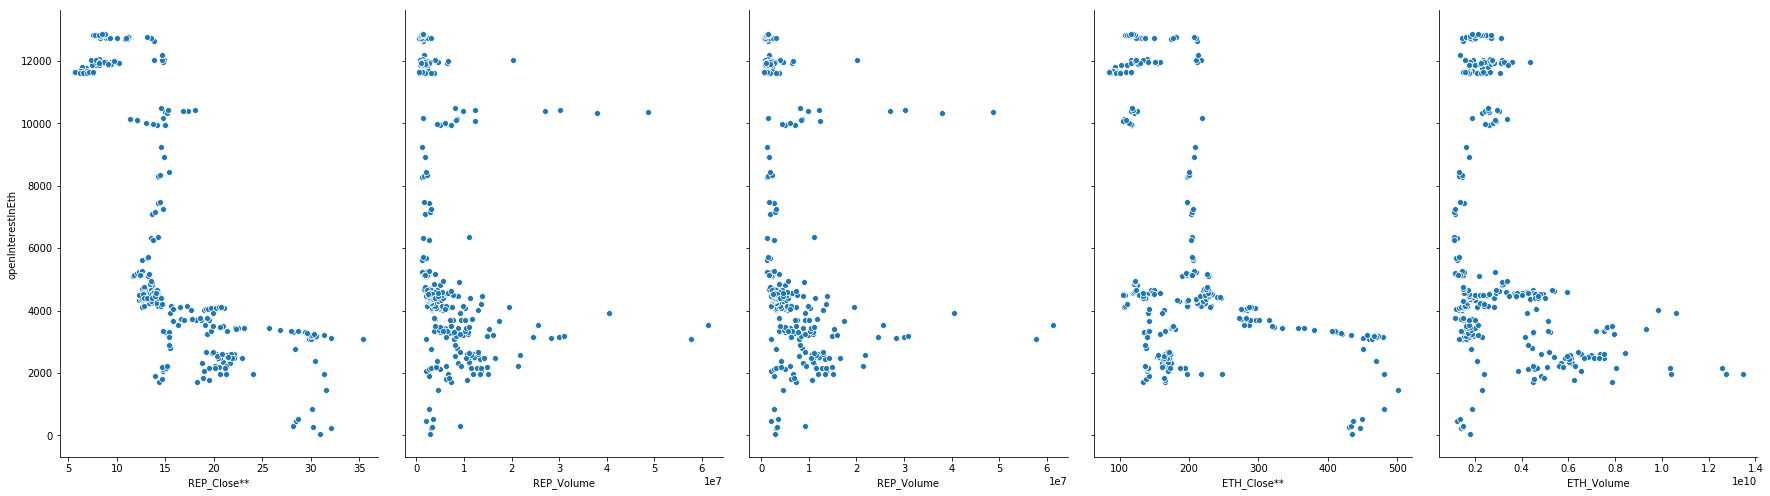

In [33]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(model_data, x_vars=[ 'REP_Close**', 'REP_Volume','REP_Volume',
       'ETH_Close**', 'ETH_Volume'], y_vars='openInterestInEth', size=7, aspect=0.7)

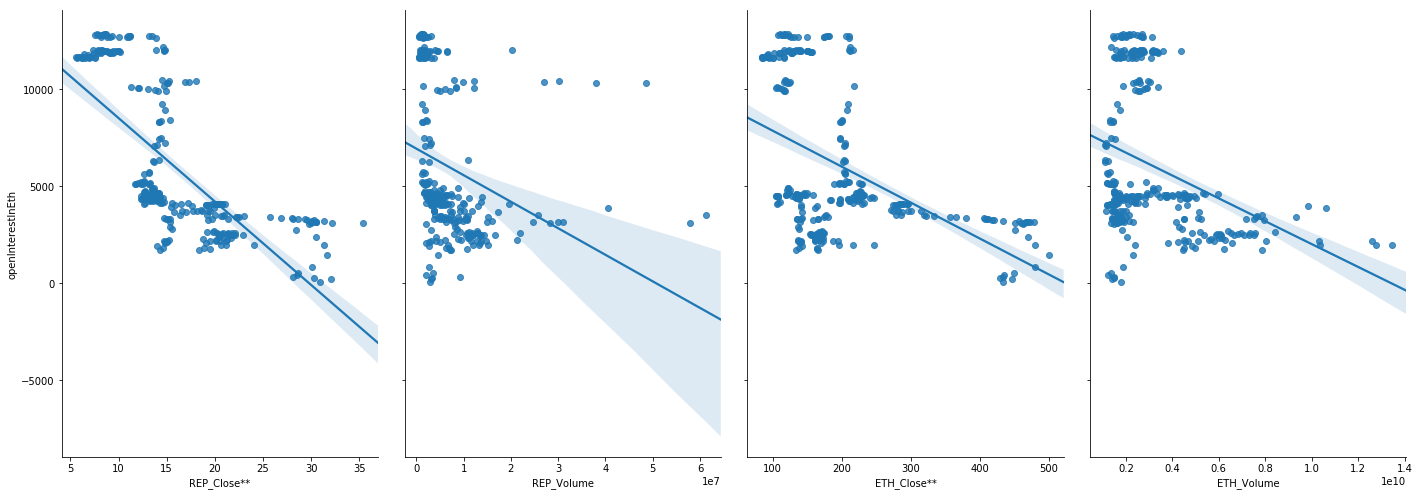

In [34]:
sns.pairplot(model_data, x_vars=['REP_Close**','REP_Volume',
       'ETH_Close**', 'ETH_Volume'], y_vars='openInterestInEth', height=7, aspect=0.7, kind='reg')

### Checking correlation of target variable with other predictor variables. So that the columns with high correlation can be removed. It is important to avoid the overfitting of our models.

In [35]:
model_data.corr()

,openInterestInEth,REP_Close**,REP_Volume,ETH_Close**,ETH_Volume
openInterestInEth,1.000000,-0.705863,-0.281188,-0.472492,-0.336011
REP_Close**,-0.705863,1.000000,0.478334,0.825446,0.246508
REP_Volume,-0.281188,0.478334,1.000000,0.244822,0.455740
ETH_Close**,-0.472492,0.825446,0.244822,1.000000,-0.076856
ETH_Volume,-0.336011,0.246508,0.455740,-0.076856,1.000000


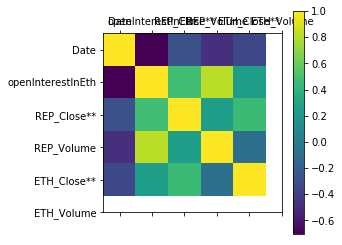

In [36]:
import matplotlib.pyplot as plt
plt.matshow(model_data.corr())
plt.xticks(range(len(model_data.columns)), model_data.columns)
plt.yticks(range(len(model_data.columns)), model_data.columns)
plt.colorbar()
plt.show()

In [37]:
model_data.fillna(method='pad', inplace=True)
model_data = model_data.dropna()
#pd.isnull(model_data).sum() > 0

In [38]:
model_data.columns

Index(['Date', 'openInterestInEth', 'REP_Close**', 'REP_Volume', 'ETH_Close**',
       'ETH_Volume'],
      dtype='object')

### Having assembled our dataset we are now able to try and make price predictions for REP using the growth numbers. We can do that with a simple model like a linear regression or a random forest from sklearn (https://scikit-learn.org/), or whatever other machine learning package you may be familiar with. What's the initial prediction loss for this model. 


In [39]:
X = model_data[['REP_Close**', 'REP_Volume', 'ETH_Close**',
       'ETH_Volume']]
y = np.array(model_data['openInterestInEth'].tolist()) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [40]:
# Grid Search for Parameter Tuning 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.model_selection import GridSearchCV

# prepare a range of alpha values to test
k_range = np.array([1,2,3,4,5,6,7,8,9,10])

knn = KNeighborsRegressor(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid=dict(n_neighbors=k_range), cv= 5)
grid.fit(X, y)
print("grid:",grid)

# summarize the results of the grid search
print("grid.best_score_:",grid.best_score_)
print("grid.best_estimator_:",grid.best_estimator_.n_neighbors)

# Model for best neighbour
model = KNeighborsRegressor(n_neighbors=10)
knn = model.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

#MSE
print ("Initial prediction loss - MSE", mean_squared_error(y_test, knn.predict(X_test)))

grid: GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None,
          n_neighbors=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
grid.best_score_: -24.910788008477287
grid.best_estimator_: 4
Initial prediction loss - MSE 10482223.810709875


In [41]:
df_X = X
df_y = y

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_X)

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, df_y, random_state=0)

linreg = LinearRegression().fit(X_train_p, y_train_p)

print('(poly deg 2) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train_p, y_train_p)))
print('(poly deg 2) R-squared score (test): {:.3f}\n'
     .format(linreg.score(X_test_p, y_test_p)))
#MSE loss function
print ("Mean Square error", mean_squared_error(y_test_p, linreg.predict(X_test_p)))

(poly deg 2) linear model coeff (w):
[ 0.00000000e+00  1.01166927e-04 -7.01165845e-04 -5.13310803e-05
  5.69224552e-07 -1.43625894e-04  6.22282620e-05 -2.27644438e-03
 -1.76314533e-07  3.80205811e-12 -2.55051189e-06 -1.23979432e-14
 -3.51330822e-02  6.90400824e-09  8.67607873e-17]
(poly deg 2) R-squared score (training): 0.609
(poly deg 2) R-squared score (test): 0.036

Mean Square error 14414703.681076072


In [42]:
linreg = Ridge().fit(X_train_p, y_train_p)

print('(poly deg 2 + ridge) linear model coeff (w):\n{}'
     .format(linreg.coef_))
print('(poly deg 2 + ridge) R-squared score (training): {:.3f}'
     .format(linreg.score(X_train_p, y_train_p)))
print('(poly deg 2 + ridge) R-squared score (test): {:.3f}'
     .format(linreg.score(X_test_p, y_test_p)))
#MSE loss function
print ("Mean Square error", mean_squared_error(y_test_p, linreg.predict(X_test_p)))


dump(linreg, '../models/linreg.joblib') 

(poly deg 2 + ridge) linear model coeff (w):
[ 0.00000000e+00 -1.81307775e+03 -9.74506217e-05  2.22817703e+01
 -7.68241538e-07  2.19149338e+01  3.69999838e-05  2.21236507e+00
 -1.24004657e-08  4.84462043e-13 -2.12353275e-06 -1.68245489e-14
 -1.31062328e-01  2.82186374e-09  2.24552934e-17]
(poly deg 2 + ridge) R-squared score (training): 0.738
(poly deg 2 + ridge) R-squared score (test): 0.547
Mean Square error 6777501.611890019


['../models/linreg.joblib']

### Are there any particularly strong pricing indicators on the historical dataset?  Is it possible to make better predictions by transforming your historical data somehow?


In [44]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
 
X = model_data[['REP_Close**', 'REP_Volume','ETH_Close**', 'ETH_Volume']]
y = np.array(model_data['openInterestInEth'].tolist()) 
names = ['REP_Close**', 'REP_Volume','ETH_Close**', 'ETH_Volume']
 
rf = RandomForestRegressor(n_estimators=20, max_depth=4)
scores = []
for i in range(X.shape[1]):
     score = cross_val_score(rf, X.iloc[:, i:i+1], y, scoring="r2",
                              cv=ShuffleSplit(len(X), 6, .3))
     scores.append((round(np.mean(score), 3), names[i]))
print (sorted(scores, reverse=True))

[(0.153, 'REP_Close**'), (-0.082, 'REP_Volume'), (-0.368, 'ETH_Close**'), (-0.507, 'ETH_Volume')]


### How would you go about improving your model?

#### By opting for Long Short Term Memory (LSTM) model which typically perform well on temporal data